## Access Kaggle
Serveral things you need to do to access Kaggle
- Sign in to Kaggle and join the competition called **BCI Homework 3 Kaggle Judge** (using the link we provide in the document)

- Create your own kaggle API token (in your account->API)
  
  <img src="https://i.imgur.com/Gia6TwE.png" alt="drawing" width="800"/>
- Upload API token (.json file) to Colab 

   <img src="https://i.imgur.com/xjEXBYs.png" alt="drawing" width="200"/>

In [ ]:
!mkdir -p /root/.kaggle
!mv kaggle.json /root/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!kaggle competitions list

## Download Dataset from Kaggle

In [ ]:
!kaggle competitions download -c bci-homework-3-kaggle-judge
!unzip -qq bci-homework-3-kaggle-judge.zip -d ./
!ls -l BCI_hw3_dataset

 96% 270M/282M [00:03<00:00, 144MB/s]
100% 282M/282M [00:03<00:00, 83.7MB/s]
total 16
-rw-r--r-- 1 root root  269 Apr 12 08:33 data_detail.json
drwxr-xr-x 2 root root 4096 Apr 12 10:11 labeled_test
drwxr-xr-x 2 root root 4096 Apr 12 10:11 train
drwxr-xr-x 2 root root 4096 Apr 12 10:11 unlabeled_test


## Install Package (Optional)

In [ ]:
!pip install torchinfo
!pip install mne

## Import Package and Library to Python Session

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
import torch.nn.functional as F

from matplotlib import pyplot as plt
from scipy.io import loadmat
from scipy.io import savemat
import numpy as np
import math
import time
import csv
import mne
import sys
import os

DATASET_DIR = "BCI_hw3_dataset/train"
DATASET_DIR_TEST = "BCI_hw3_dataset/labeled_test"
DATASET_DIR_EXAM = "BCI_hw3_dataset/unlabeled_test"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## EEG Model

### EEGNet

In [ ]:
class EEGNet(nn.Module):
    """EEGNet model from Lawhern et al 2018.
    ... Parameters ............
    C: int
        Number of EEG input channels.
    N: int
        Number of EEG input time samples.
    nb_classes: int
        Number of classes to predict.
    kernLength: int
        Length of temporal convolution in first layer.
    F1, F2: int
        Number of temporal filters (F1) and number of pointwise filters (F2) to learn.
    D: int
        Number of spatial filters to learn within each temporal convolution.
    dropoutRate: float
        Dropout ratio.
    ... References ............
    https://arxiv.org/abs/1611.08024
    """
    def __init__(self, C, N, nb_classes, kernLength=64, F1=8, F2=16, D=2, dropoutRate=0.5):
        super(EEGNet, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(1, F1, (1, kernLength), padding="valid", bias=False),
            nn.BatchNorm2d(F1, eps=1e-3, momentum=0.99)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                F1, D * F1, (C, 1), groups=F1, bias=False
            ),
            nn.BatchNorm2d(D * F1, eps=1e-3, momentum=0.99),
            nn.ELU(),
            nn.AvgPool2d((1, 4)),
            nn.Dropout(dropoutRate)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(
                D * F1, D * F1, (1, 16),
                padding=(0, 8), groups=D * F1, bias=False
            ),
            nn.Conv2d(D * F1, F2, (1, 1), bias=False),
            nn.BatchNorm2d(F2, eps=1e-3, momentum=0.99),
            nn.ELU(),
            nn.AvgPool2d((1, 8)),
            nn.Dropout(dropoutRate)
        )

        fc_inSize = self.get_size(C, N)[1]
        self.classifier = nn.Linear(fc_inSize, nb_classes, bias=True)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size()[0], -1)
        x = self.classifier(x)
        return x

    def get_size(self, C, N):
        data = torch.ones((1, 1, C, N))
        x = self.conv1(data)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size()[0], -1)
        return x.size()


### ShallowConvNet

In [ ]:
class ShallowConvNet(nn.Module):
    """Shallow ConvNet model from Schirrmeister et al 2017.
    ... Parameters ............
    C: int
        Number of EEG input channels.
    N: int
        Number of EEG input time samples.
    nb_classes: int
        Number of classes to predict.
    NT: int
        Number of temporal filters.
    NS: int
        Number of spatial filters.
    tkerLen: int
        Length of the temporal filter.
    pool_tLen: int
        Length of temporal pooling filter.
    pool_tStep: int
        Length of stride of temporal pooling filters.
    batch_norm: bool
        Whether to use batch normalization.
    dropRate: float
        Dropout ratio.
    ... References ............
    https://arxiv.org/abs/1703.05051
    """
    def __init__(self, C, N, nb_classes, NT=40, NS=40, tkerLen=12, pool_tLen=35, pool_tStep=7, batch_norm=True, dropRate=0.25):
        super(ShallowConvNet, self).__init__()

        self.conv1 = nn.Conv2d(1, NT, (1, tkerLen), bias=False)
        self.conv2 = nn.Conv2d(NT, NS, (C, 1), bias=False)
        self.Bn1 = nn.BatchNorm2d(NS)
        self.AvgPool1 = nn.AvgPool2d((1, pool_tLen), stride=(1, pool_tStep))
        self.Drop1 = nn.Dropout(dropRate)
        fc_inSize = self.get_size(C, N)[1]
        self.classifier = nn.Linear(fc_inSize, nb_classes, bias=True)
        self.batch_norm = batch_norm

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        if self.batch_norm:
            x = self.Bn1(x)
        x = x ** 2
        x = self.AvgPool1(x)
        x = torch.log(x)
        x = self.Drop1(x)
        x = x.view(x.size()[0], -1)
        x = self.classifier(x)
        return x
    
    def get_size(self, C, N):
        data = torch.ones((1, 1, C, N))
        x = self.conv1(data)
        x = self.conv2(x)
        x = self.AvgPool1(x)
        x = x.view(x.size()[0], -1)
        return x.size()


### SCCNet

In [ ]:
# (Bonus) Optional TODO: Advanced SCCNet model without permutation layer
class SCCNet_v2(nn.Module):
    """Advanced SCCNet model without permutation layer.
    ... Parameters ............
    C: int
        Number of EEG input channels.
    N: int
        Number of EEG input time samples.
    nb_classes: int
        Number of classes to predict.
    Nu: int
        Number of spatial kernel.
    Nt: int
        Length of spatial kernel.
    Nc: int
        Number of spatial-temporal kernel.
    fs: float
        Sampling frequency of EEG input.
    dropoutRate: float
        Dropout ratio.
    ... References ............
    https://ieeexplore.ieee.org/document/8716937
    """
    def __init__(self, C, N, nb_classes, Nu=None, Nt=1, Nc=20, fs=1000.0, dropoutRate=0.5):
        super(SCCNet_v2, self).__init__()
        Nu = C if Nu is None else Nu
        # self.layer = ...

    def forward(self, x):
        return x


In [ ]:
# TODO: finish the SCCNet
class SCCNet(nn.Module):
    """SCCNet model from Wei et al 2019.
    ... Parameters ............
    C: int
        Number of EEG input channels.
    N: int
        Number of EEG input time samples.
    nb_classes: int
        Number of classes to predict.
    Nu: int
        Number of spatial kernel.
    Nt: int
        Length of spatial kernel.
    Nc: int
        Number of spatial-temporal kernel.
    fs: float
        Sampling frequency of EEG input.
    dropoutRate: float
        Dropout ratio.
    ... References ............
    https://ieeexplore.ieee.org/document/8716937
    """
    # You can only add extra argument to this function, do NOT remove the existed arguments
    # The model structure should be dynamic changed by the provided arguments,
    # There will be a score penalty if SCCNet structure is static
    def __init__(self, C, N, nb_classes, Nu=None, Nt=1, Nc=20, fs=1000.0, dropoutRate=0.5): 
        super(SCCNet, self).__init__()
        Nu = C if Nu is None else Nu
        ### TODO: construct the model layers, refer to paper ###
        # self.layer = ...

    def forward(self, x):
        ### TODO: forwarding rule ###
        # ex. x = self.layer(x)
        # note. remember the square activation and log activation
        return x

    def get_size(self):
        # Optional TODO: auto calculate fully-connected layer helper function
        return x.size()

class Permute2d(nn.Module):
    def __init__(self, shape):
        super(Permute2d, self).__init__()
        self.shape = shape

    def forward(self, x):
        return torch.permute(x, self.shape)

## Train

In [ ]:
# config training scheme, mode, hyperparam
eegmodel = SCCNet # function alias, should be EEGNet, ShallowConvNet, SCCNet, SCCNet_v2
kwargs = dict(fs=125.0, dropoutRate=0.5) # custom args for different EEG model
scheme = "ind"  # "ind", "si", "sd", "sift"
epochs = 200
batch_size = 16
lr = 1e-3
savepath = "checkpoints"
os.makedirs(savepath, exist_ok=True)

subject_id = "01"

### load data

In [ ]:
mat_T = loadmat(os.path.join(DATASET_DIR, f"BCIC_S{subject_id}_T.mat"))
x_data, y_data = mat_T["x_train"], mat_T["y_train"].squeeze()
x_train = np.zeros((0, *x_data.shape[1:]), dtype=x_data.dtype)
y_train = np.zeros((0, ), dtype=y_data.dtype)
x_valid = np.zeros((0, *x_data.shape[1:]), dtype=x_data.dtype)
y_valid = np.zeros((0, ), dtype=y_data.dtype)

if scheme == "si" or scheme == "sift":
    ### TODO: subject-independent training scheme, subject-independent + fine-tuning shared same training data representaion ###

elif scheme == "sd": # subject-dependent, target `subject` participate in training stage, `testing data should still be LEAVE-OUT`
    ### TODO: subject-dependent training scheme ###
    
else:  # default subject-individual
    mat_T = loadmat(os.path.join(DATASET_DIR, f"BCIC_S{subject_id}_T.mat")) # load the .mat file
    x_data, y_data = mat_T["x_train"], mat_T["y_train"].squeeze()

    # simple train-valid split, only consider class balance (may not good enough), CAN be modified
    for c in range(4):
        x_, y_ = x_data[y_data == c], y_data[y_data == c]
        x_train = np.append(x_train, x_[:54], axis=0)
        y_train = np.append(y_train, y_[:54], axis=0)
        x_valid = np.append(x_valid, x_[54:], axis=0)
        y_valid = np.append(y_valid, y_[54:], axis=0)

# numpy array to tensor
x_train = torch.from_numpy(x_train)
y_train = torch.from_numpy(y_train).long()
x_valid = torch.from_numpy(x_valid)
y_valid = torch.from_numpy(y_valid).long()

# tensor reshape for training
x_train = x_train.unsqueeze(1)
y_train = F.one_hot(y_train, 4)
x_valid = x_valid.unsqueeze(1)
y_valid = F.one_hot(y_valid, 4)

print("train: {}, {}".format(x_train.size(), y_train.size()))
print("valid: {}, {}".format(x_valid.size(), y_valid.size()))

# build training and validation dataloader
trainset = torch.utils.data.TensorDataset(x_train, y_train)
validset = torch.utils.data.TensorDataset(x_valid, y_valid)
tra_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(validset, batch_size=batch_size, shuffle=True, num_workers=2)

train: torch.Size([1944, 1, 22, 562]), torch.Size([1944, 4])
valid: torch.Size([648, 1, 22, 562]), torch.Size([648, 4])


### training stage

In [ ]:
# train an epoch, evaluate an epoch
# if you are familiar with Pytorch, you CAN custom these function
#  such as adding the lr_scheduler to optimize the training progress

def train_an_epoch(model, data_loader, loss_fn, optimizer):
    model.train()

    a, b = 0, 0  # hit sample, total sample
    epoch_loss = np.zeros((len(data_loader), ))
    for i, (x_batch, y_batch) in enumerate(data_loader):
        x_batch, y_batch = x_batch.to(device, dtype=torch.float), y_batch.to(device, dtype=torch.float)
        ### TODO ###
        # TODO: zero grad optimizer
        output = # TODO: get model prediction
        loss = # TODO: calc loss
        # TODO: back propagation
        # TODO: step the optimizer
        
        epoch_loss[i] = loss.item()
        b += y_batch.size(0)
        a += torch.sum(y_batch.argmax(dim=1) == output.argmax(dim=1)).item()
    return epoch_loss.mean(), a / b  # return the loss and acc

def evalate_an_epoch(model, data_loader, loss_fn):
    model.eval()
    a, b = 0, 0 # hit sample, total sample
    epoch_loss = np.zeros((len(data_loader), ))
    for i, (x_batch, y_batch) in enumerate(data_loader):
        x_batch, y_batch = x_batch.to(device, dtype=torch.float), y_batch.to(device, dtype=torch.float)
        ### TODO ###
        output = # TODO: get model prediction
        loss = # TODO: calc loss

        epoch_loss[i] = loss.item()
        b += y_batch.size(0)
        a += torch.sum(y_batch.argmax(dim=1) == output.argmax(dim=1)).item()
    return epoch_loss.mean(), a / b  # return the loss and acc


In [ ]:
model = eegmodel(x_train.size(2), x_train.size(3), 4, **kwargs)
loss_fn = nn.CrossEntropyLoss()  # loss function, can be modified
opt_fn = torch.optim.Adam(model.parameters(), lr=lr)  # optimizer, CAN be modified
# sche_fn = torch.optim.lr_scheduler.<???> # optional

# dump the model structure
summary(model, input_size=(batch_size, *list(x_train.size()[1:])))

/usr/local/lib/python3.9/dist-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/usr/local/lib/python3.9/dist-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type:depth-idx)                   Output Shape              Param #
SCCNet                                   [16, 4]                   --
├─Sequential: 1-1                        [16, 1, 22, 562]          --
│    └─Conv2d: 2-1                       [16, 22, 1, 562]          506
│    └─Permute2d: 2-2                    [16, 1, 22, 562]          --
│    └─BatchNorm2d: 2-3                  [16, 1, 22, 562]          2
├─Sequential: 1-2                        [16, 20, 1, 564]          --
│    └─Conv2d: 2-4                       [16, 20, 1, 564]          5,740
│    └─BatchNorm2d: 2-5                  [16, 20, 1, 564]          40
├─Dropout: 1-3                           [16, 20, 1, 564]          --
├─AvgPool2d: 1-4                         [16, 20, 1, 39]           --
├─Linear: 1-5                            [16, 4]                   3,124
Total params: 9,412
Trainable params: 9,412
Non-trainable params: 0
Total mult-adds (M): 56.40
Input size (MB): 0.79
Forward/backward pass size (MB):

In [ ]:
# if you are familiar with Pytorch, you CAN custom the following training loop

hist = dict(
    loss=np.zeros((epochs, )), val_loss=np.zeros((epochs, )),
    acc=np.zeros((epochs, )), val_acc=np.zeros((epochs, ))
)
clock_ini = time.time()
for ep in range(epochs):
    loss, acc = train_an_epoch(model, tra_loader, loss_fn, opt_fn)
    loss, acc = evalate_an_epoch(model, tra_loader, loss_fn)
    val_loss, val_acc = evalate_an_epoch(model, val_loader, loss_fn)
    print("Epoch {}: loss={:.4f}, acc={:.4f}, val_loss={:.4f}, val_acc={:.4f}".format(ep, loss, acc, val_loss, val_acc))
    hist["loss"][ep] = loss
    hist["acc"][ep] = acc
    hist["val_loss"][ep] = val_loss
    hist["val_acc"][ep] = val_acc

    if True:
        # save the pre-trained weight in each epoch, CAN be modified
        checkpoint = dict(epoch=-1, state_dict=model.state_dict(), loss=loss, val_loss=val_loss)
        torch.save(checkpoint, os.path.join(savepath, f"TORCH_MODEL_NAME-ep{ep}.pth"))
print("time spend: {:.2f} sec".format(time.time() - clock_ini))

Epoch 0: loss=1.3841, acc=0.2176, val_loss=1.3936, val_acc=0.2222
Epoch 1: loss=1.3773, acc=0.2407, val_loss=1.3883, val_acc=0.2500
Epoch 2: loss=1.3674, acc=0.2870, val_loss=1.3814, val_acc=0.3194
Epoch 3: loss=1.3531, acc=0.3981, val_loss=1.3710, val_acc=0.2778
Epoch 4: loss=1.3283, acc=0.3796, val_loss=1.3509, val_acc=0.3611
Epoch 5: loss=1.3131, acc=0.5556, val_loss=1.3383, val_acc=0.4028
Epoch 6: loss=1.2773, acc=0.5833, val_loss=1.3064, val_acc=0.4722
Epoch 7: loss=1.1909, acc=0.5185, val_loss=1.2352, val_acc=0.5000
Epoch 8: loss=1.1341, acc=0.5556, val_loss=1.1741, val_acc=0.5556
Epoch 9: loss=1.0795, acc=0.5694, val_loss=1.1254, val_acc=0.5556
Epoch 10: loss=1.2188, acc=0.4815, val_loss=1.2273, val_acc=0.4444
Epoch 11: loss=0.9776, acc=0.6019, val_loss=1.0235, val_acc=0.5000
Epoch 12: loss=0.9219, acc=0.5694, val_loss=0.9412, val_acc=0.5417
Epoch 13: loss=0.9847, acc=0.5833, val_loss=1.0384, val_acc=0.4583
Epoch 14: loss=0.9034, acc=0.5694, val_loss=0.9467, val_acc=0.5694
Epoch

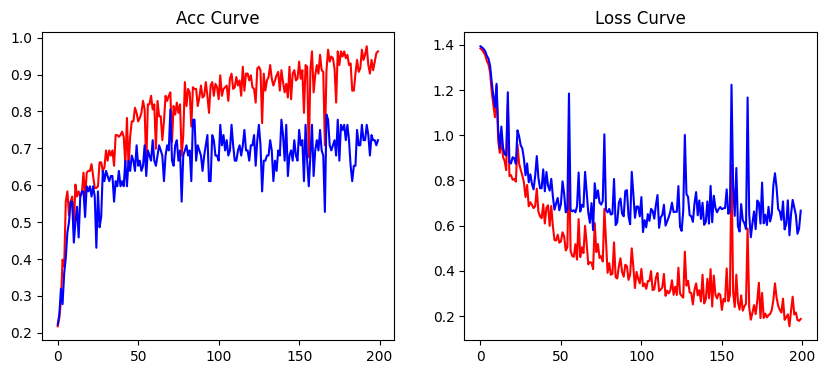

In [ ]:
# Acc curve, Loss curve
plt.figure(figsize = (10, 4))
plt.subplot(1, 2, 1)
plt.title("Acc Curve")
plt.plot(hist["acc"], color="red")
plt.plot(hist["val_acc"], color="blue")
plt.subplot(1, 2, 2)
plt.title("Loss Curve")
plt.plot(hist["loss"], color="red")
plt.plot(hist["val_loss"], color="blue")
plt.show()

### fine-tuning (SI+FT)

In [ ]:
### TODO: build the fine-tuning dataloader ###


# load pre-trained model
### TODO ###
ep_num = # TODO: the pre-trained epoch you want to tuning
model_path = os.path.join(savepath, "{}-ep{}.pth".format("TORCH_MODEL_NAME", ep_num))
checkpoint = torch.load(model_path, map_location="cpu")  # load .pth
model.load_state_dict(checkpoint["state_dict"])  # set model weight

# # Optional: lock pre-trained weight
# for param in model.parameters():
#     param.requires_grad = False

### TODO: fine-tuning training loop ###


## Test

In [ ]:
# load pre-trained model
best_epoch = # TODO: determine the `BEST` epoch
test_model_path = os.path.join(savepath, "{}-ep{}.pth".format("TORCH_MODEL_NAME", best_epoch))
checkpoint = torch.load(test_model_path, map_location="cpu")  # load .pth
model.load_state_dict(checkpoint["state_dict"])  # set model weight

# testing on subject S01 test (E) session
mat = loadmat(os.path.join(DATASET_DIR_TEST, f"BCIC_S01_E.mat"))
x, y = mat["x_test"], mat["y_test"].squeeze()
x = torch.from_numpy(x)
y = torch.from_numpy(y).long()
x = x.unsqueeze(1)
y = F.one_hot(y, 4)

print("test: {}, {}".format(x.size(), y.size()))

testset = torch.utils.data.TensorDataset(x, y)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
evalate_an_epoch(model, test_loader, loss_fn)

test: torch.Size([288, 1, 22, 562]), torch.Size([288, 4])


(0.5535194658570819, 0.7118055555555556)

## Analyzing
You need to do some further analysis including
- confusion matrix, 
- topographic maps for spatial kernel weights in SCCNet

You need to do these on your own in this section

In [ ]:
# mne doc: https://mne.tools/stable/python_reference.html
# "data_detail.json" in BCI_hw3_dataset/ provides you with all channel names in this dataset. It will help you to plot a topoplot.


## Generate Submission csv File

In [ ]:
eegmodel = SCCNet # function alias, should be EEGNet, ShallowConvNet, SCCNet, SCCNet_v2
kwargs = dict(fs=125.0, dropoutRate=0.5) # custom args for different EEG model
model = eegmodel(22, 562, 4, **kwargs)
best_epoch = hist["val_loss"].argmin()
test_model_path = os.path.join(savepath, "{}-ep{}.pth".format("TORCH_MODEL_NAME", best_epoch))
checkpoint = torch.load(test_model_path, map_location="cpu") 
model.load_state_dict(checkpoint["state_dict"])

model.eval()
fd = open("simple_sd.csv", "w")
csv_writer = csv.writer(fd)
csv_writer.writerow(["id", "Category"])
for sid in ["05", "06", "0A", "0B", "0C"]:
    mat = loadmat(os.path.join(DATASET_DIR_EXAM, f"BCIC_S{sid}_E.mat"))
    x = torch.from_numpy(mat["x_test"])
    x = x.unsqueeze(1).to(device, dtype=torch.float)
    p = model(x).argmax(dim=1).detach().cpu().numpy()
    for epoch_id, label in enumerate(p):
        csv_writer.writerow([f"S{sid}_{epoch_id}", label])
fd.close()